# Paper reproduction : The power of Ensembbles for Active Learning in Image Classification

The objective of this project is to replicate the experiments of the baseline __[The power of ensembles for active learning in image classification](https://openaccess.thecvf.com/content_cvpr_2018/html/Beluch_The_Power_of_CVPR_2018_paper.html)__ from William H. Beluch et. al., (CVPR), 2018, pp. 9368-9377.

In particular, the experiments on the MNIST dataset.

This notebooks stores the main experiments and results of this project.

# Introduction on Active Learning

The idea of active learning is to efficiently anotate unlabeled instances and add it to the data base.

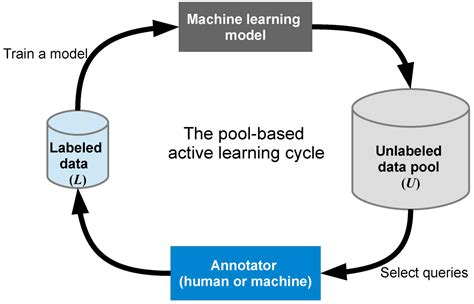

while criterion() :

    model = get_model(L)

    unlabeled_data = select_data(model, U)
    
    data = query_oracle(unlabeled_data)
    
    L = L ∪ data
    
    U = U\unlabeled_data

In [1]:
#Import packages
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets as dts
from torchvision.transforms import ToTensor 

import matplotlib.pyplot as plt
import numpy as np
import random
import json

# Load datsets

## MNIST dataset

In [2]:
#Load MNIST dataset
train_mnist = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = False,            
)
test_mnist = dts.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
    download = False,         
)

## Cifar10 dataset

In [3]:
#Load CIFAR10
train_cifar10 = dts.CIFAR10(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = False,            
)

test_cifar10 = dts.CIFAR10(
    root = 'data', 
    train = False, 
    transform = ToTensor(),
    download = False,         
)

## Define dataloaders

In [4]:
#Hyperparameter
BATCH_SIZE = 32

#Get MNIST loaders
trainldr_mnist = torch.utils.data.DataLoader(train_mnist, batch_size=BATCH_SIZE, shuffle=True)
testldr_mnist = torch.utils.data.DataLoader(test_mnist, batch_size=BATCH_SIZE, shuffle=False)

#Get CIFAR10 loaders
trainldr_cifar10 = torch.utils.data.DataLoader(train_cifar10, batch_size=BATCH_SIZE, shuffle=True)
testldr_cifar10 = torch.utils.data.DataLoader(test_cifar10, batch_size=BATCH_SIZE, shuffle=False)

# Models

## Model definitions

In [5]:
#Reference "https://github.com/lunayht/DBALwithImgData/blob/main/cnn_model.py"

class S_CNN(nn.Module):
    def __init__(self, device='cpu'):
        super(S_CNN, self).__init__()
        
        #Convolution layers
        self.conv1 = nn.Conv2d(1, 32, 4)
        self.conv2 = nn.Conv2d(32, 32, 4)
        
        #Dropout layers
        self.drop1 = nn.Dropout(p=0.25)
        self.drop2 = nn.Dropout(p=0.5)
        
        #Fully connected layers
        self.lin1 = nn.Linear(3872, 128) #11*11*32
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop1(x)
        x = torch.flatten(x, 1) #Latten space
        x = self.lin1(x)
        x = F.relu(x)
        x = self.drop2(x)
        out = self.lin2(x)
        return out
    
    def encode(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        out = self.lin1(x)
        
        return out

In [6]:
#Reference "https://github.com/Xinyi6/CIFAR10-CNN-by-Keras/blob/master/lic/model2_2.ipynb"

class K_CNN(nn.Module):
    def __init__(self, device='cpu'):
        super(K_CNN,self).__init__()
        
        #Convolution layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        
        #Dropout layers
        self.drop1 = nn.Dropout(p=0.3)
        self.drop2 = nn.Dropout(p=0.3)
        self.drop3 = nn.Dropout(p=0.4)
        self.drop4 = nn.Dropout(p=0.4)
        self.drop5 = nn.Dropout(p=0.3)
        
        #Fully connected layers
        self.lin1 = nn.Linear(3872, 128) #11*11*32
        self.lin2 = nn.Linear(128, 10)

    def forward(self, x):
        
        #Convolution layers
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop3(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop4(x)
        
        #linear layers
        x = torch.flatten(x, 1)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.drop5(x)
        out = self.lin2(x)
        return out
    
    def encode(self, x):
        
        #Convolution layers
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.drop3(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        out = self.drop4(x)
        
        return out

## Train

### Train settings

In [7]:
# Settings from the paper
EPOCHS = {'S_CNN':50, 'K_CNN':150, 'DENSE':100, 'INCEPTIONV3':150, 'RESNET50':150} #Epochs in each iteration
DATASET = {'S_CNN':'MNIST', 'K_CNN':'CIFAR10', 'DENSE':'CIFAR10', 'INCEPTIONV3':'DIABETIC', 'RESNET50':'IMAGENET'} #Dataset used for each model
TRAIN_VAL_SPLIT = {'MNIST':(58000, 2000), 'CIFAR10':(58000, 2000), 'DIABETIC':(67961, 3000), 'IMAGENET':(1281167,10000)} #Number of train and validation instances
DATA_ADQUISITION = {'S_CNN':(20,20,1000,2000), 'K_CNN':(200,400,9800,4000), 'DENSE':(500,2000,14500,20000), 'INCEPTIONV3':(1000,5000,21000,30000), 'RESNET50':(40000,40000,280000,400000)} #Initial train size, train size increments per iteration, total train size, pool subsample size
OPTIMIZER = {'S_CNN':'ADAM', 'K_CNN':'RMSprop', 'DENSE':'SGD', 'INCEPTIONV3':{'RMSprop 20', 'SGD'}, 'RESNET50':'SGD'} #Optimizer used for training
LEARNING_RATE = {'S_CNN':0.001, 'K_CNN':0.001, 'DENSE':(0.0001, 0.9), 'INCEPTIONV3':0.001, 'RESNET50':{0:0.1, 50:0.01, 75:0.001}} #Double check. Not mentioned properly
INITIALIZATION = 'GLOROT' #Initializer used
REPETITION_EXPERIMENT = 5 #Number of experiments used for each setting (used to compute mean and std)

In [8]:
def get_info(model_type='S_CNN'):
    
    #Set info variable setting
    info = {'model_type':model_type}
    info['epochs'] = EPOCHS[model_type]
    info['dataset_name'] = DATASET[model_type]
    info['train_val_split'] = TRAIN_VAL_SPLIT[info['dataset_name']]
    info['data_adquisition'] = DATA_ADQUISITION[model_type]
    info['optimizer'] = OPTIMIZER[model_type]
    info['learning_rate'] = LEARNING_RATE[model_type]
    info['initialization'] = 'GLOROT'
    info['repetitions'] = 5
    
    return info

### Train functions

In [9]:
#Training procedure
def train(model, data_loader, info, log=True):
    
    #Initialize parameters
    model.train()
    loss_fn = torch.nn.CrossEntropyLoss()
    total_step = len(data_loader)
    
    #Get training setting
    epochs = info['epochs']
    lr = info['learning_rate']
    if info['optimizer'] == 'ADAM':
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    elif info['optimizer'] == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr = lr)
    elif info['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    else:
        raise Exception(f'[ERROR] Optimizer not implemented ({info["optimizer"]}) | train()')
        
    #Main loop
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader): 
            
            # Get loss 
            pred = model(x)
            loss = loss_fn(pred, y)
            
            # Backpropagation
            optimizer.zero_grad()           
            loss.backward()          
            optimizer.step()                
            
            #Log
            if log and (i+1) % 100 == 0:
                print(f'Epoch: [{epoch+1}/{epochs}], Step: [{i+1}/{total_step}], Loss: {loss.item()}')
    #print(f"x:\n  - Type: {type(x)}\n  - dtype: {x.dtype}\n  - Shape: {x.shape}\n")
    #print(f"y:\n  - Type: {type(y)}\n  - dtype: {y.dtype}\n  - Shape: {y.shape}\n")

In [10]:
#Get accuracy
def get_accuracy(model, data_loader):
    
    #Initialize parameters
    model.eval()
    with torch.no_grad():
        corct = 0
        total = 0
        
        #Main loop
        for (x, y) in data_loader:
            pred = model(x)
            pred = torch.max(pred, 1)[1].data.squeeze()
            corct += (pred == y).sum().item()
            total += len(y)
            
    #Return accuracy
    acc = corct/total
    return acc

In [11]:
#Get accuracy for Markov Models
def get_accuracy_mc(model, data_loader, passes=25):
    
    #Initialize parameters
    model.train()
    with torch.no_grad():
        corct = 0
        total = 0
        
        #Main loop
        for (x, y) in data_loader:
            
            #Average over mc passes
            pred = model(x)
            for i in range(passes-1):
                pred += model(x)
            pred /= passes
            
            #Get accuracy
            pred = torch.max(pred, 1)[1].data.squeeze()
            corct += (pred == y).sum().item()
            total += len(y)
            
    #Return accuracy
    acc = corct/total
    return acc

In [12]:
#Get accuracy for Encemble
def get_accuracy_ensemble(models, data_loader, passes=25):
    
    #Initialize parameters
    model.train()
    with torch.no_grad():
        corct = 0
        total = 0
        
        #Main loop
        for (x, y) in data_loader:
            
            #Average over mc passes
            model = models[0]
            pred = model(x)
            for model in models[1:]:
                pred += model(x)
            pred /= passes
            
            #Get accuracy
            pred = torch.max(pred, 1)[1].data.squeeze()
            corct += (pred == y).sum().item()
            total += len(y)
            
    #Return accuracy
    acc = corct/total
    return acc

In [13]:
#Get test metrics
def test(model, data_loader):
    
    #Initialize parameters
    model.eval()
    with torch.no_grad():
        loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
        loss = 0
        corct = 0
        total = 0
        
        #Main loop
        for (x, y) in data_loader:
            pred = model(x)
            pred_class = torch.max(pred, 1)[1].data.squeeze()
            loss += loss_fn(pred, y).item()
            corct += (pred_class == y).sum().item()
            total += len(y)
            
    #Return accuracy
    loss = loss/total
    acc = corct/total
    return loss, acc

In [14]:
#Get test metrics
def test_mc(model, data_loader, passes=25):
    
    #Initialize parameters
    model.train()
    with torch.no_grad():
        loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
        loss = 0
        corct = 0
        total = 0
        
        #Main loop
        for (x, y) in data_loader:
            
            #Average over mc passes
            pred = model(x)
            for i in range(passes-1):
                pred += model(x)
            pred /= passes
            
            pred_class = torch.max(pred, 1)[1].data.squeeze()
            loss += loss_fn(pred, y).item()
            corct += (pred_class == y).sum().item()
            total += len(y)
            
    #Return accuracy
    loss = loss/total
    acc = corct/total
    return loss, acc

In [15]:
#Get test metrics
def test_ensemble(models, data_loader, passes=25):
    
    #Initialize parameters
    with torch.no_grad():
        loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
        loss = 0
        corct = 0
        total = 0
        n_ens = len(models)
        
        #Main loop
        for (x, y) in data_loader:
            
            #Average over ensemble
            model = models[0]
            model.train()
            pred = model(x)
            for model in models[1:]:
                model.train()
                pred += model(x)
            pred /= n_ens
            
            pred_class = torch.max(pred, 1)[1].data.squeeze()
            loss += loss_fn(pred, y).item()
            corct += (pred_class == y).sum().item()
            total += len(y)
            
    #Return accuracy
    loss = loss/total
    acc = corct/total
    return loss, acc

# Active learning

## Active learning criterions

In [16]:
def get_random(model, data, data_size_increment):
    
    result = torch.randperm(len(data))[:data_size_increment].numpy()
    result.sort()
    return result

### Active Learning single model

In [17]:
def get_entropy(model, data, data_size_increment):
    
    #Initialize parameters
    entropy = []
    model.eval()
    
    #Main loop over dataset
    for (x,y) in data:
        x = x.unsqueeze(0)
        pred = model(x)
        prob = F.softmax(pred, dim=1)
        h = torch.sum(torch.log(prob)*prob).item()
        entropy.append(h)
        
    #Return entropy list
    instances_values = np.array(entropy)
    instances_idx_subsample = instances_values.argsort()[:data_size_increment]
    instances_idx_subsample.sort()
    
    return instances_idx_subsample

In [18]:
def get_margin(model, data, data_size_increment):
    
    #Initialize parameters
    margin = []
    model.eval()
    
    #Main loop over dataset
    for (x,y) in data:
        x = x.unsqueeze(0)
        pred = model(x)
        prob = F.softmax(pred, dim=1)
        pos1 = torch.argmax(prob)
        prob1 = prob[0,pos1].item()
        prob[0,pos1] = 0
        prob2 = torch.max(prob).item()
        m = prob1 - prob2
        margin.append(m)
        
    #Return idx list
    instances_values = np.array(margin)
    instances_idx_subsample = instances_values.argsort()[:data_size_increment]
    instances_idx_subsample.sort()
    
    return instances_idx_subsample

In [19]:
def get_least_confidence(model, data, data_size_increment):
    
    #Initialize parameters
    uncertainty = []
    
    x_data = torch.stack([x for (x,y) in data])
    model.eval()
    pred = model(x_data)
    prob = F.softmax(pred, dim=1)
    certainty, _ = torch.max(prob, dim=1)
    
    #Loop over instances to add
    for i in range(data_size_increment):
        
        #Get new instance
        c_min, c_argmin = torch.min(certainty, 0)
        c_argmin = c_argmin.item()
        
        #Update result
        uncertainty.append(c_argmin)
        certainty[c_argmin] = 1
        
    #Return idx list
    instances_values = np.array(uncertainty)
    instances_idx_subsample = instances_values.argsort()[:data_size_increment]
    instances_idx_subsample.sort()
    
    return instances_idx_subsample

In [20]:
def get_core_set_greedy(model, data_subsample, data_labeled, data_size_increment, encoder=None):
    
    #Define variables
    core_set = []
    
    #Calculate min L2 distance (diff) to data labeled for any instance in data_subsample
    
    if encoder is None:
        x_data = torch.stack([x for (x,y) in data_subsample])
        x_data_l = torch.stack([x for (x,y) in data_labeled])
    else:
        encoder.eval()
        x_data = torch.squeeze(torch.stack([encoder.encode(x.unsqueeze(0)) for (x,y) in data_subsample]), 1)
        x_data_l = torch.squeeze(torch.stack([encoder.encode(x.unsqueeze(0)) for (x,y) in data_labeled]), 1)
    
    data_shape = list(x_data.size())
    data_ = torch.unsqueeze(x_data, 0)
    
    data_l_shape = list(x_data_l.size())
    data_l_ = torch.unsqueeze(x_data_l, 0)
    
    data_exp = data_.expand([data_l_shape[0]] + data_shape)
    data_l_exp = data_l_.expand([data_shape[0]] + data_l_shape)
    
    data_l_exp = torch.transpose(data_l_exp, 0, 1)
    
    if encoder is None:
        diff = torch.sum((data_exp-data_l_exp)**2, (2,3,4))
    else:
        diff = torch.sum((data_exp-data_l_exp)**2, (2))
    d_min, _ = torch.min(diff, 0)
    
    #Loop over instances to add
    for i in range(data_size_increment):
        
        #Get new instance
        v_max, v_argmax = torch.max(d_min, 0)
        v_argmax = v_argmax.item()
        
        #Update result
        core_set.append(v_argmax)
        x_new = data_subsample[v_argmax][0]
        
        #Update min L2 distances
        if encoder is None:
            dist_new = torch.sum((x_data-x_new.unsqueeze(0))**2, (1,2,3))
        else:
            dist_new = torch.sum((x_data-encoder.encode(x_new.unsqueeze(0)))**2, (1))
        d_min = torch.minimum(d_min, dist_new)
            
    #Return idx result
    core_set.sort()
    return core_set

In [21]:
def get_loss_cheat(model, data, data_size_increment):
    
    #Initialize parameters
    queried_indices = []
    
    x_data = torch.stack([x for (x,y) in data])
    y_data = torch.Tensor([y for (x,y) in data]).type(torch.int64)
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
    model.eval()
    
    #Get loss
    pred = model(x_data)
    loss = loss_fn(pred, y_data)
    
    #Get elemenets with highest loss
    for i in range(data_size_increment):
        
        #Get new instance
        c_argmax = torch.argmax(loss).item()
        
        #Update result
        queried_indices.append(c_argmax)
        loss[c_argmax] = 0
        
    #Return idx list
    instances_values = np.array(queried_indices)
    instances_idx_subsample = instances_values.argsort()[:data_size_increment]
    instances_idx_subsample.sort()
    
    return instances_idx_subsample

### Active Learning Monte-Carlo model

In [22]:
def get_var_ratio_mc(model, data, data_size_increment, passes=25):
    
    #Initialize parameters
    uncertainty = []
    
    x_data = torch.stack([x for (x,y) in data])
    model.train()
    pred = model(x_data)
    prob = F.one_hot(torch.max(pred, dim=1).indices, num_classes=10)
    
    for i in range(passes-1):
        pred = model(x_data)
        prob += F.one_hot(torch.max(pred, dim=1).indices, num_classes=10)
        
    mode, _ = torch.max(prob, dim=1)
    
    #Loop over instances to add
    for i in range(data_size_increment):
        
        #Get new instance
        c_min, c_argmin = torch.min(mode, 0)
        c_argmin = c_argmin.item()
        
        #Update result
        uncertainty.append(c_argmin)
        mode[c_argmin] = 1
        
    #Return idx list
    instances_values = np.array(uncertainty)
    instances_idx_subsample = instances_values.argsort()[:data_size_increment]
    instances_idx_subsample.sort()
    
    return instances_idx_subsample

### Active Learning Ensemble model

In [23]:
def get_var_ratio_ens(ens_models, data, data_size_increment):
    
    #Initialize parameters
    uncertainty = []
    x_data = torch.stack([x for (x,y) in data])
    n_models = len(ens_models)
    
    model = ens_models[0]
    model.eval()
    pred = model(x_data)
    prob = F.one_hot(torch.max(pred, dim=1).indices, num_classes=10)
    
    for model in ens_models[1:]:
        model.eval()
        pred = model(x_data)
        prob += F.one_hot(torch.max(pred, dim=1).indices, num_classes=10)
        
    mode, _ = torch.max(prob, dim=1)
    
    #Loop over instances to add
    for i in range(data_size_increment):
        
        #Get new instance
        c_min, c_argmin = torch.min(mode, 0)
        c_argmin = c_argmin.item()
        
        #Update result
        uncertainty.append(c_argmin)
        mode[c_argmin] = n_models
        
    #Return idx list
    instances_values = np.array(uncertainty)
    instances_idx_subsample = instances_values.argsort()[:data_size_increment]
    instances_idx_subsample.sort()
    
    return instances_idx_subsample

## Active Learning training setting

In [24]:
#Single model

def al_learning_single(dataset, valid_datalder, info, seeds=[0,1,2,3,4], log=True, procedure='random'):
    
    #Initialize histograme
    histograme = {'acc':[], 'loss':[], 'data_size':[], 'procedure':procedure}
    get_instances = True
    
    #Initialize data related settings
    data_adquisition = info['data_adquisition']
    data_size_start = data_adquisition[0]
    data_size_increment = data_adquisition[1]
    data_size_max = data_adquisition[2]
    data_size_subsample = data_adquisition[3]
    num_al_steps = (data_size_max-data_size_start)//data_size_increment + 1
    
    #Get experiment info
    model_type = info['model_type']
    repetitions = info['repetitions']
    
    #Main loop over experiment repetitions
    for j in range(repetitions):
        
        #Initialize histograme for repetition
        histograme_rep = {'acc':[], 'loss':[], 'data_size':[], 'procedure':procedure}
    
        #Set seed
        torch.manual_seed(seeds[j])
        random.seed(seeds[j])
        
        #Define datasets indices for labeled and unlabeled pool
        dataset_unlabeled_indeces = list(range(len(dataset)))
        dataset_labeled_indeces = random.sample(dataset_unlabeled_indeces, data_size_start)
        dataset_labeled_indeces.sort()
        for idx in dataset_labeled_indeces[::-1]:
            del dataset_unlabeled_indeces[idx]
        
        #Loop over AL steps
        for i in range(num_al_steps):

            #Initialize data
            dataset_labeled = [dataset[i] for i in dataset_labeled_indeces]
            dataset_unlabeled_subsample_indices = random.sample(dataset_unlabeled_indeces, data_size_subsample)
            dataset_unlabeled_subsample = [dataset[i] for i in dataset_unlabeled_subsample_indices]
            dataloader_labeled = torch.utils.data.DataLoader(dataset_labeled, batch_size=BATCH_SIZE, shuffle=True)

            #Define model
            if model_type == 'S_CNN':
                model = S_CNN()
            elif model_type == 'K_CNN':
                model = K_CNN()
            else:
                raise Exception(f'[ERROR] Model not implemented ({model_type}) | al_learning()')

            #Train model
            train(model, dataloader_labeled, info, log=False)
            loss, acc = test(model, valid_datalder)

            #Save accuracy
            acc_hist = histograme_rep['acc']
            acc_hist.append(acc)
            histograme_rep['acc'] = acc_hist

            #Save loss
            loss_hist = histograme_rep['loss']
            loss_hist.append(loss)
            histograme_rep['loss'] = loss_hist

            #Save data size
            data_size_hist = histograme_rep['data_size']
            data_size_hist.append(len(dataset_labeled))
            histograme_rep['data_size'] = data_size_hist

            #Show log
            if log and i%10==0:
                print(f'Repetition: [{j+1}/{repetitions}], AL step: [{i+1}/{num_al_steps}], loss: {round(loss,4)}, acc: {round(acc,4)}, dataset size: {len(dataset_labeled)}')

            #Get unlabeled instances value
            if procedure == 'random':
                instances_idx_subsample = get_random(model, dataset_unlabeled_subsample, data_size_increment)
            elif procedure == 'entropy':
                instances_idx_subsample = get_entropy(model, dataset_unlabeled_subsample, data_size_increment)
            elif procedure == 'margin':
                instances_idx_subsample = get_margin(model, dataset_unlabeled_subsample, data_size_increment)
            elif procedure == 'least_confidence':
                instances_idx_subsample = get_least_confidence(model, dataset_unlabeled_subsample, data_size_increment)
            elif procedure == 'core_set_greedy':
                instances_idx_subsample = get_core_set_greedy(model, dataset_unlabeled_subsample, dataset_labeled, data_size_increment)
            elif procedure == 'core_set_greedy_emb':
                instances_idx_subsample = get_core_set_greedy(model, dataset_unlabeled_subsample, dataset_labeled, data_size_increment, encoder=model)
            elif procedure == 'core_set_greedy_emb':
                instances_idx_subsample = get_core_set_greedy(model, dataset_unlabeled_subsample, dataset_labeled, data_size_increment, encoder=model)
            elif procedure == 'loss_cheat':
                instances_idx_subsample = get_loss_cheat(model, dataset_unlabeled_subsample, data_size_increment)
            else:
                raise Exception(f'[ERROR] Procedure not implemented ({procedure}) | al_learning()')

            #Update datasets indeces
            for k in instances_idx_subsample[::-1]:
                instances_idx = dataset_unlabeled_subsample_indices[k]
                dataset_labeled_indeces.append(instances_idx)
                del dataset_unlabeled_subsample_indices[k]
                
            dataset_labeled_indeces.sort()
                
        #Update histograme acc
        acc_hist = histograme['acc']
        acc_hist.append(histograme_rep['acc'])
        histograme['acc'] = acc_hist

        #Update histograme loss
        loss_hist = histograme['loss']
        loss_hist.append(histograme_rep['loss'])
        histograme['loss'] = loss_hist

        #Update histograme data size
        data_size_hist = histograme['data_size']
        data_size_hist.append(histograme_rep['data_size'])
        histograme['data_size'] = data_size_hist
            
    #Return histograme    
    return histograme 

In [25]:
#Monte-Carlo model

def al_learning_mc(dataset, valid_datalder, info, seeds=[0,1,2,3,4], log=True, procedure='random', passes=25):
    
    #Initialize histograme
    histograme = {'acc':[], 'loss':[], 'data_size':[], 'procedure':procedure +' MC'}
    get_instances = True
    
    #Initialize data related settings
    data_adquisition = info['data_adquisition']
    data_size_start = data_adquisition[0]
    data_size_increment = data_adquisition[1]
    data_size_max = data_adquisition[2]
    data_size_subsample = data_adquisition[3]
    num_al_steps = (data_size_max-data_size_start)//data_size_increment + 1
    
    #Get experiment info
    model_type = info['model_type']
    repetitions = info['repetitions']
    
    #Main loop over experiment repetitions
    for j in range(repetitions):
        
        #Initialize histograme for repetition
        histograme_rep = {'acc':[], 'loss':[], 'data_size':[], 'procedure':procedure +' MC'}
    
        #Set seed
        torch.manual_seed(seeds[j])
        random.seed(seeds[j])
        
        #Define datasets indices for labeled and unlabeled pool
        dataset_unlabeled_indeces = list(range(len(dataset)))
        dataset_labeled_indeces = random.sample(dataset_unlabeled_indeces, data_size_start)
        dataset_labeled_indeces.sort()
        for idx in dataset_labeled_indeces[::-1]:
            del dataset_unlabeled_indeces[idx]
        
        #Loop over AL steps
        for i in range(num_al_steps):

            #Initialize data
            dataset_labeled = [dataset[i] for i in dataset_labeled_indeces]
            dataset_unlabeled_subsample_indices = random.sample(dataset_unlabeled_indeces, data_size_subsample)
            dataset_unlabeled_subsample = [dataset[i] for i in dataset_unlabeled_subsample_indices]
            dataloader_labeled = torch.utils.data.DataLoader(dataset_labeled, batch_size=BATCH_SIZE, shuffle=True)

            #Define model
            if model_type == 'S_CNN':
                model = S_CNN()
            elif model_type == 'K_CNN':
                model = K_CNN()
            else:
                raise Exception(f'[ERROR] Model not implemented ({model_type}) | al_learning_mc()')

            #Train model
            train(model, dataloader_labeled, info, log=False)
            loss, acc = test_mc(model, valid_datalder, passes=passes)

            #Save accuracy
            acc_hist = histograme_rep['acc']
            acc_hist.append(acc)
            histograme_rep['acc'] = acc_hist

            #Save loss
            loss_hist = histograme_rep['loss']
            loss_hist.append(loss)
            histograme_rep['loss'] = loss_hist

            #Save data size
            data_size_hist = histograme_rep['data_size']
            data_size_hist.append(len(dataset_labeled))
            histograme_rep['data_size'] = data_size_hist

            #Show log
            if log and i%10==0:
                print(f'Repetition: [{j+1}/{repetitions}], AL step: [{i+1}/{num_al_steps}], loss: {round(loss,4)}, acc: {round(acc,4)}, dataset size: {len(dataset_labeled)}')

            #Get unlabeled instances value
            if procedure == 'random':
                instances_idx_subsample = get_random(model, dataset_unlabeled_subsample, data_size_increment, passes=passes)
            elif procedure == 'var_ratio':
                instances_idx_subsample = get_var_ratio_mc(model, dataset_unlabeled_subsample, data_size_increment, passes=passes)
            else:
                raise Exception(f'[ERROR] Procedure implemented ({procedure}) | al_learning_mc()')

            #Update datasets indeces
            for k in instances_idx_subsample[::-1]:
                instances_idx = dataset_unlabeled_subsample_indices[k]
                dataset_labeled_indeces.append(instances_idx)
                del dataset_unlabeled_subsample_indices[k]
                
            dataset_labeled_indeces.sort()
                
        #Update histograme acc
        acc_hist = histograme['acc']
        acc_hist.append(histograme_rep['acc'])
        histograme['acc'] = acc_hist

        #Update histograme loss
        loss_hist = histograme['loss']
        loss_hist.append(histograme_rep['loss'])
        histograme['loss'] = loss_hist

        #Update histograme data size
        data_size_hist = histograme['data_size']
        data_size_hist.append(histograme_rep['data_size'])
        histograme['data_size'] = data_size_hist
            
    #Return histograme    
    return histograme 

In [26]:
#Ensemble model

def al_learning_ensemble(dataset, valid_datalder, info, seeds=[[0,1,2,3,4],[5,6,7,8,9],[10,11,12,13,14],[15,16,17,18,19],[20,21,22,23,24]], log=True, procedure='random'):
    
    #Initialize histograme
    histograme = {'acc':[], 'loss':[], 'data_size':[], 'procedure':procedure + ' ENS'}
    get_instances = True
    
    #Initialize data related settings
    data_adquisition = info['data_adquisition']
    data_size_start = data_adquisition[0]
    data_size_increment = data_adquisition[1]
    data_size_max = data_adquisition[2]
    data_size_subsample = data_adquisition[3]
    num_al_steps = (data_size_max-data_size_start)//data_size_increment + 1
    
    #Get experiment info
    model_type = info['model_type']
    repetitions = info['repetitions']
    
    #Main loop over experiment repetitions
    for j in range(repetitions):
        
        #Initialize histograme for repetition
        histograme_rep = {'acc':[], 'loss':[], 'data_size':[], 'procedure':procedure + ' ENS'}
    
        #Set seed
        torch.manual_seed(seeds[j][0])
        random.seed(seeds[j][0])
        
        #Define datasets indices for labeled and unlabeled pool
        dataset_unlabeled_indeces = list(range(len(dataset)))
        dataset_labeled_indeces = random.sample(dataset_unlabeled_indeces, data_size_start)
        dataset_labeled_indeces.sort()
        for idx in dataset_labeled_indeces[::-1]:
            del dataset_unlabeled_indeces[idx]
        
        #Loop over AL steps
        for i in range(num_al_steps):

            #Initialize data
            dataset_labeled = [dataset[i] for i in dataset_labeled_indeces]
            dataset_unlabeled_subsample_indices = random.sample(dataset_unlabeled_indeces, data_size_subsample)
            dataset_unlabeled_subsample = [dataset[i] for i in dataset_unlabeled_subsample_indices]
            dataloader_labeled = torch.utils.data.DataLoader(dataset_labeled, batch_size=BATCH_SIZE, shuffle=True)
            
            #Initialize ensemble
            ens_models = []
            for k in seeds[j]:
                #Set seed
                torch.manual_seed(k)
                random.seed(k)
                
                #Define model
                if model_type == 'S_CNN':
                    model = S_CNN()
                elif model_type == 'K_CNN':
                    model = K_CNN()
                else:
                    raise Exception(f'[ERROR] Model not implemented ({model_type}) | al_learning_ensemble()')

                #Train model
                train(model, dataloader_labeled, info, log=False)
                ens_models.append(model)
            
            #Get loss, acc
            loss, acc = test_ensemble(ens_models, valid_datalder)

            #Save accuracy
            acc_hist = histograme_rep['acc']
            acc_hist.append(acc)
            histograme_rep['acc'] = acc_hist

            #Save loss
            loss_hist = histograme_rep['loss']
            loss_hist.append(loss)
            histograme_rep['loss'] = loss_hist

            #Save data size
            data_size_hist = histograme_rep['data_size']
            data_size_hist.append(len(dataset_labeled))
            histograme_rep['data_size'] = data_size_hist

            #Show log
            if log and i%10==0:
                print(f'Repetition: [{j+1}/{repetitions}], AL step: [{i+1}/{num_al_steps}], loss: {round(loss,4)}, acc: {round(acc,4)}, dataset size: {len(dataset_labeled)}')

            #Get unlabeled instances value
            if procedure == 'random':
                instances_idx_subsample = get_random(model, dataset_unlabeled_subsample, data_size_increment)
            elif procedure == 'var_ratio':
                instances_idx_subsample = get_var_ratio_ens(ens_models, dataset_unlabeled_subsample, data_size_increment)
            else:
                raise Exception(f'[ERROR] Procedure not implemented ({procedure}) | al_learning_ensemble()')

            #Update datasets indeces
            for k in instances_idx_subsample[::-1]:
                instances_idx = dataset_unlabeled_subsample_indices[k]
                dataset_labeled_indeces.append(instances_idx)
                del dataset_unlabeled_subsample_indices[k]
                
            dataset_labeled_indeces.sort()
                
        #Update histograme acc
        acc_hist = histograme['acc']
        acc_hist.append(histograme_rep['acc'])
        histograme['acc'] = acc_hist

        #Update histograme loss
        loss_hist = histograme['loss']
        loss_hist.append(histograme_rep['loss'])
        histograme['loss'] = loss_hist

        #Update histograme data size
        data_size_hist = histograme['data_size']
        data_size_hist.append(histograme_rep['data_size'])
        histograme['data_size'] = data_size_hist
            
    #Return histograme    
    return histograme 

In [27]:
def plot_hist_single(histograme_list):
    #Plot some images
    fig, axs = plt.subplots(1, 2, figsize=(16,5))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    legend = []
    lines = []
    
    #Loop over hostogrames
    for i, histograme in enumerate(histograme_list):
        
        #Get data to plot
        acc = np.array(histograme['acc'])
        loss = np.array(histograme['loss'])
        data_size = np.array(histograme['data_size'])[0]
        
        #Get mean and std
        acc_mean = np.mean(acc, axis=0)
        acc_std = np.std(acc, axis=0)
        
        loss_mean = np.mean(loss, axis=0)
        loss_std = np.std(loss, axis=0)

        #Plot acc and loss over dataset size
        line_i, = axs[0].plot(data_size, acc_mean, colors[i])
        axs[0].fill_between(data_size, np.maximum(acc_mean - acc_std, 0), np.minimum(acc_mean + acc_std, 1), color=colors[i], alpha=0.2)
        
        axs[1].plot(data_size, loss_mean, colors[i])
        axs[1].fill_between(data_size, np.maximum(loss_mean - loss_std, 0), loss_mean + loss_std, color=colors[i], alpha=0.2)
        
        #Update legend info
        legend.append(histograme['procedure'])
        lines.append(line_i)
        
    #Set graph labels
    axs[0].set_title(f'Accuracy')
    axs[1].set_title(f'Loss')
        
    #Set legend
    axs[0].legend(lines, legend)
    axs[1].legend(lines, legend)
    
    #Set grid
    axs[0].grid(which="major", alpha=0.6)
    axs[0].grid(which="minor", alpha=0.3)
    
    axs[1].grid(which="major", alpha=0.6)
    axs[1].grid(which="minor", alpha=0.3)

# Experiments

## S_CNN

In [28]:
model_type = 'S_CNN'
info = get_info(model_type)

In [29]:
raise Exception('STOP EXECUTION CELL')

Exception: STOP EXECUTION CELL

In [ ]:
hist_rand_single = al_learning_single(train_mnist, testldr_mnist, info)

In [ ]:
hist_entropy_single = al_learning_single(train_mnist, testldr_mnist, info, procedure='entropy')

In [ ]:
hist_margin_single = al_learning_single(train_mnist, testldr_mnist, info, procedure='margin')

In [ ]:
hist_least_confidence_single = al_learning_single(train_mnist, testldr_mnist, info, procedure='least_confidence')

In [ ]:
hist_coreset_greedy_single = al_learning_single(train_mnist, testldr_mnist, info, procedure='core_set_greedy')

In [ ]:
hist_coreset_greedy_embedding_single = al_learning_single(train_mnist, testldr_mnist, info, procedure='core_set_greedy_emb')

In [ ]:
hist_loss_cheat_single = al_learning_single(train_mnist, testldr_mnist, info, procedure='loss_cheat')

In [ ]:
hist_rand_mc = al_learning_mc(train_mnist, testldr_mnist, info)

In [ ]:
hist_var_ratio_mc = al_learning_mc(train_mnist, testldr_mnist, info, procedure='var_ratio')

In [ ]:
hist_rand_ens = al_learning_ensemble(train_mnist, testldr_mnist, info)

In [ ]:
hist_var_ratio_ens = al_learning_ensemble(train_mnist, testldr_mnist, info, procedure='var_ratio')

## Save and load results

In [ ]:
#Save results
# with open("results/s_cnn/example", "w") as fp:
#     json.dump(example, fp) 

In [30]:
#Load results
with open('results/s_cnn/hist_rand_single') as f:
    hist_rand_single = json.load(f)
    
with open('results/s_cnn/hist_entropy_single') as f:
    hist_entropy_single = json.load(f)
    
with open('results/s_cnn/hist_margin_single') as f:
    hist_margin_single = json.load(f)
    
with open("results/s_cnn/hist_coreset_greedy_single") as f:
    hist_coreset_greedy_single = json.load(f) 
    
with open("results/s_cnn/hist_coreset_greedy_embedding_single") as f:
    hist_coreset_greedy_embedding_single = json.load(f) 
    
with open("results/s_cnn/hist_least_confidence_single") as f:
    hist_least_confidence_single = json.load(f) 
    
with open("results/s_cnn/hist_loss_cheat_single") as f:
    hist_loss_cheat_single = json.load(f) 
    
with open("results/s_cnn/hist_rand_mc") as f:
    hist_rand_mc = json.load(f) 
    
with open("results/s_cnn/hist_var_ratio_mc") as f:
    hist_var_ratio_mc = json.load(f) 
    
with open("results/s_cnn/hist_rand_ens") as f:
    hist_rand_ens = json.load(f) 
    
with open("results/s_cnn/hist_var_ratio_ens") as f:
    hist_var_ratio_ens = json.load(f) 

# Results

## Core-set vs Core-set embeded

Comparison between standard Core-set and Core-set using the encoding of the data-points, i.e., the output of the trained model after the convolution layers (see model.enocde()).

This change is not in the original paper but it was sugested by Thorben Werner (my supervisor) since most implementations of greedy use the embedding version which is not the original implementation.

*The reason why the embedding is taken after the first dense layer and not directly after the convolution is because of the high dimension. The dimensions are so huge that the algorithm is stucked in the middle of the process and returns error of "no memory available" after some iterations.*

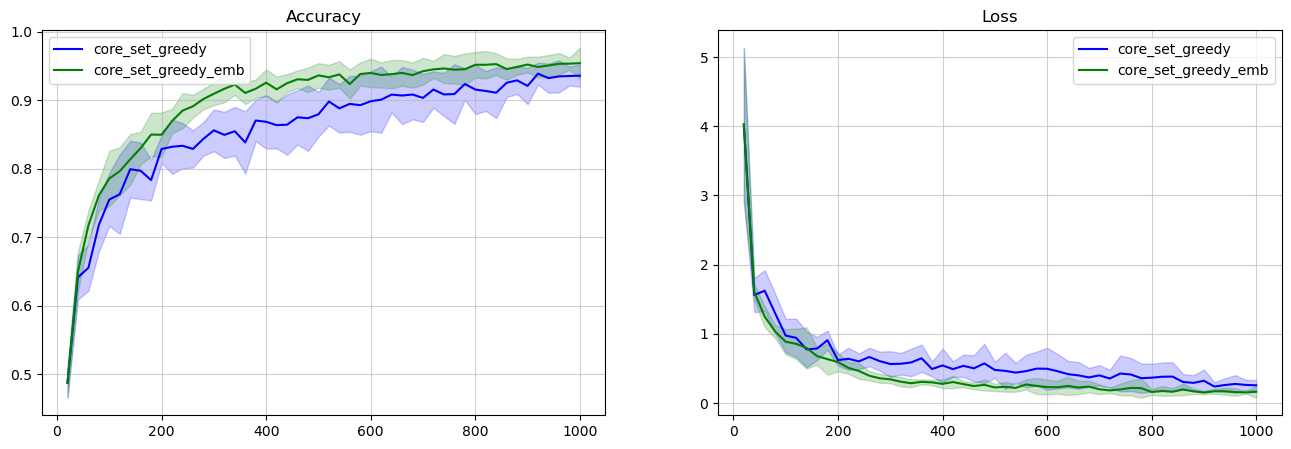

In [31]:
plot_hist_single([hist_coreset_greedy_single, hist_coreset_greedy_embedding_single])

Since the performance of the embeded one is much better than the not embeded version, from here on, only the embeded version will be considered.

Here is a table with the final results after the Active Learning procedure (1000 labeled images):

| Method | Accuracy | Loss |
| --- | --- | --- |
| Core-set Greedy | 0.936$\pm$0.0163 | 0.2551$\pm$0.0759 |
| Core-set Greedy Embeded | **0.9542$\pm$0.0225** | **0.1617$\pm$0.085** |

## Single model performance for Active-learning methods

This is a comparison when using a single model with different Active-Learning methods. The baseline only considered random, entropy and Core-set. Nevertheless, least confidence and 

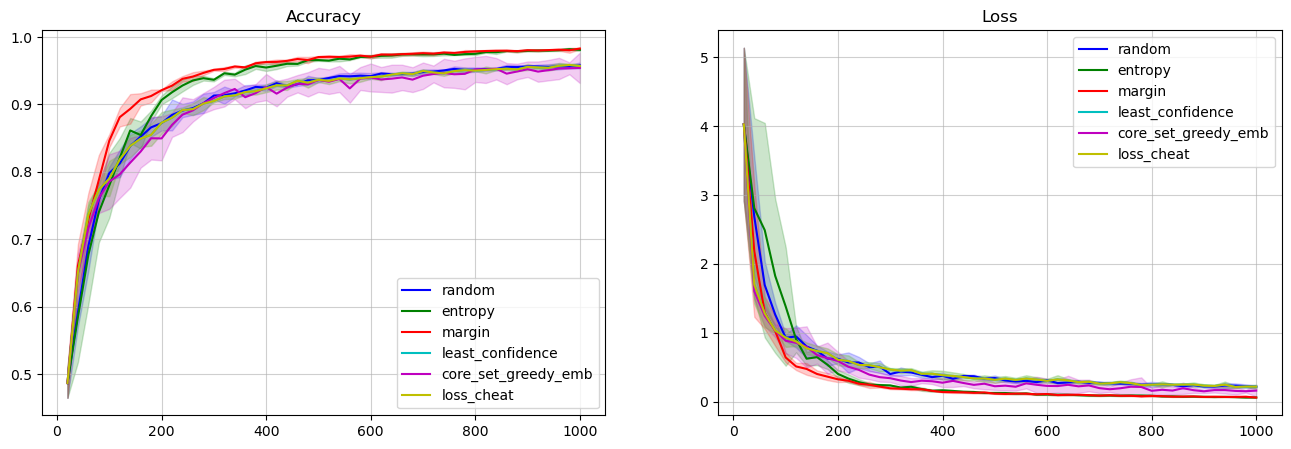

In [32]:
plot_hist_single([hist_rand_single, hist_entropy_single, hist_margin_single, hist_least_confidence_single, hist_coreset_greedy_embedding_single, hist_loss_cheat_single])

In [ ]:
def get_final_results(hist):
    #Get accuracy
    results = []
    for acc in hist['acc']:
        results.append(acc[-1])
    results = np.array(results)
    acc_mean = results.mean()
    acc_std = results.std()
    auc = np.sum(results)/len(results)
    
    #Get loss
    results = []
    for loss in hist['loss']:
        results.append(loss[-1])
    results = np.array(results)
    loss_mean = results.mean()
    loss_std = results.std()
    
    return {'acc':(acc_mean, acc_std), 'loss':(loss_mean, loss_std), 'auc':auc}

In [ ]:
round_digit = 5
for hist in [hist_rand_single, hist_entropy_single, hist_margin_single, hist_least_confidence_single, hist_coreset_greedy_embedding_single, hist_loss_cheat_single]:
    result = get_final_results(hist)
    string = f"{hist['procedure']}: {round(result['acc'][0],round_digit)}+{round(result['acc'][1],round_digit)}, "
    string += f"{round(result['loss'][0],round_digit)}+{round(result['loss'][1],round_digit)}, "
    string += f"{round(result['auc'],round_digit)}"
    print(string)

Margin and entropy are the best performing Active Learning methods. Nevertheless, Margin wasn't considered in the original paper. It is even slightly better than entropy.

The results match the ones from the paper.

Here is a table with the final results after the Active Learning procedure (1000 labeled images):

| Method | Accuracy | Loss | AUC |
| --- | --- | --- | --- |
| Margin | **0.9829$\pm$0.0011** | **0.0614$\pm$0.0015** |  **0.98292** |
| Entropy | 0.9809$\pm$0.0015 | 0.0624$\pm$0.0047 | 0.98094 |
| Random | 0.9578$\pm$0.0044 | 0.2157$\pm$0.0250 | 0.95782 |
| Least confidence | 0.9570$\pm$0.0030 | 0.2188$\pm$0.0286 | 0.957 |
| Loss cheat | 0.9570$\pm$0.0030 | 0.2188$\pm$0.0286 | 0.957 |
| Core-set embeded | 0.9542$\pm$0.0225 | 0.1617$\pm$0.0850 | 0.95424 |

### Least confidence vs loss cheat

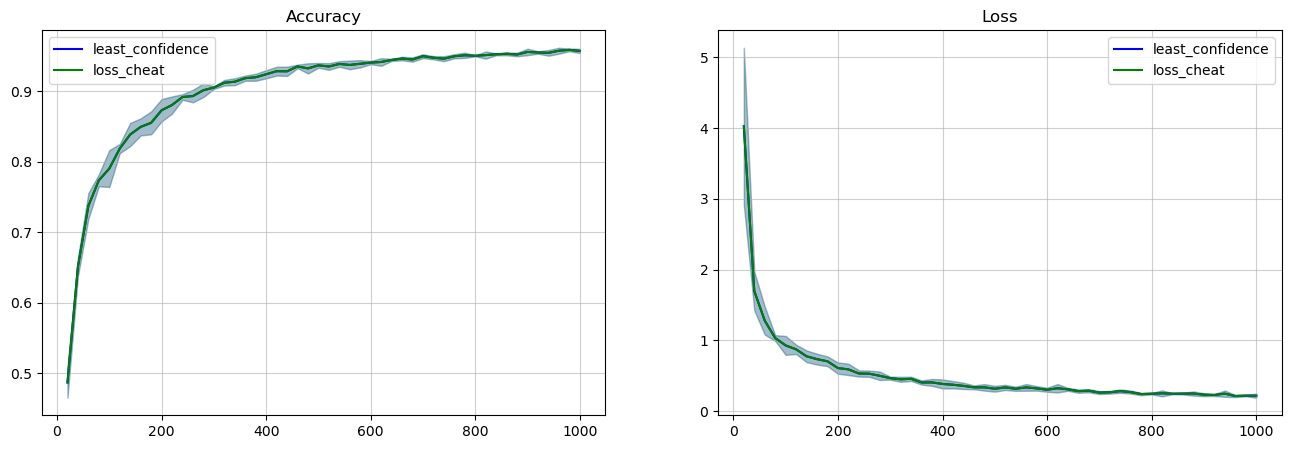

In [36]:
plot_hist_single([hist_least_confidence_single, hist_loss_cheat_single])

## Monte-Carlo (MC) Active learning methods

This methods use models with deopout layer (S_CNN() model) and use that in oreder to generate several predictions in eval mode to then average and get the final prediction.

The variational Ratio Active Learning method, consists in getting the prediction with the highest disagreement between the different predictions of the MC models.

In [ ]:
plot_hist_single([hist_rand_mc, hist_var_ratio_mc])

In the baseline paper there was an imporvemente with the variational ratio method compared to the random one. No improvement/difference was found in the experiments between random and variational ratio.

Here is a table with the final results after the Active Learning procedure (1000 labeled images):

| Method | Accuracy | Loss |
| --- | --- | --- |
| MC random | **0.9588$\pm$0.002** | **0.2184$\pm$0.0162** |
| MC varRatio | 0.9558$\pm$0.002 | 0.2293$\pm$0.0214 |

## Ensemble methods

Similar idea to MC method but train several times the same model with different seeds and then average between them to get the prediction.

The variational ratio Active Learning method is used in the same way as with MC models.

The results show some issue which I'm unable to fully understand. The code for var ratio in ensemble is almost the same as var ratio for MC setting. I'm not able to see were the issue arises.

In [ ]:
plot_hist_single([hist_rand_ens, hist_var_ratio_ens])

Again, no improvement was found when comparing random and variational ratio. The baseline did found a difference.

Here is a table with the final results after the Active Learning procedure:

| Method | Accuracy | Loss |
| --- | --- | --- |
| Ensemble random | 0.9495$\pm$0.0018 | 0.2955$\pm$0.0225 |
| Ensemble varRatio | 0.7198$\pm$0.0139 | 2.0147$\pm$0.2227 |

## Final results

Lastly I will show first a comparison of the methods used in the paper with my results and their results.

In [ ]:
plot_hist_single([hist_rand_single, hist_entropy_single, hist_coreset_greedy_embedding_single, hist_rand_mc, hist_var_ratio_mc, hist_rand_ens, hist_var_ratio_ens])



Here is a table with the final results after the Active Learning procedure:

| Method | Accuracy | Loss |
| --- | --- | --- |
| Single random | 0.9578$\pm$0.0044 | 0.2157$\pm$0.025 |
| Single entropy | **0.9809$\pm$0.0015** | **0.0624$\pm$0.0047** |
| Single Core-set | 0.9542$\pm$0.0225 | 0.1617$\pm$0.085 |
| MC random | 0.9588$\pm$0.002 | 0.2184$\pm$0.0162 |
| MC varRatio | 0.9558$\pm$0.002 | 0.2293$\pm$0.0214 |
| Ensemble random | 0.9495$\pm$0.0018 | 0.2955$\pm$0.0225 |
| Ensemble varRatio | 0.7198$\pm$0.0139 | 2.0147$\pm$0.2227 |

This are the result from the baseline:

![image](baseline_results.jpg)

No table is given with the exact results in the paper for this particular experiment.

# Conclusion

The results from the paper that claim the increase in performance using variational ratio in MC and ensemble setting do not match the results from the experiments.

The main hypothesis that could explain this discrepancy are:

* There is no direct link or explanation of the minor details of the model. This could have affected the performance (number of convolution kernels, number of convolution layers, etc...). The model S_CNN has been obtained of the a third order reference, i.e., from a reference of a reference of the baseline (https://github.com/lunayht/DBALwithImgData/blob/main/cnn_model.py). Therefore, there could be some differences between the model used in the paper and the model used in this project.

* The learning rate is not specified. 0.001 seems to work fine but maybe there are better values.

* Same seed has been used in all the settings to replicate a valid comparison. Again, there is no reference of the seeds used in the paper and I'm also unsure whether the randomness could change between different hardwares even if the same seed is used.

